<a href="https://colab.research.google.com/github/WildfiresTeam/wildfire-dataset/blob/main/Adding_WS_Bounding_Box_GeoTIFF_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/MyDrive/shapefiles


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


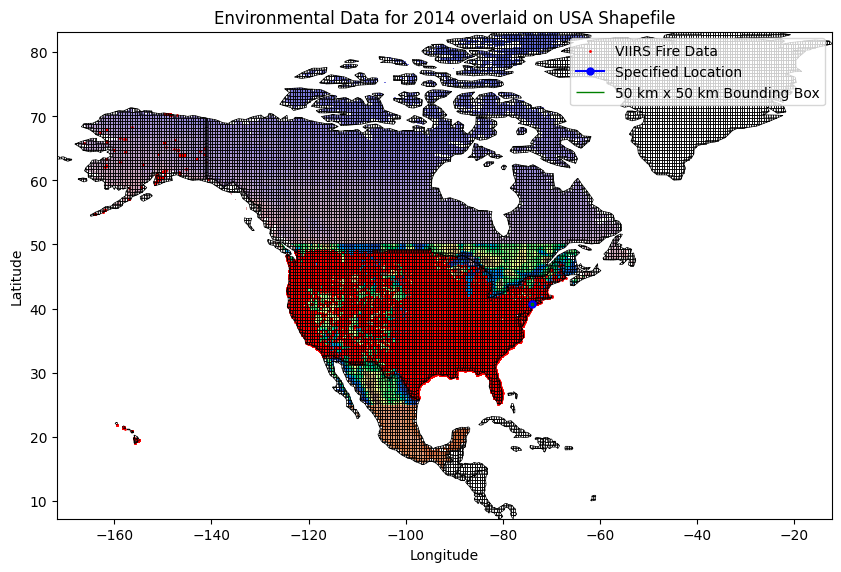

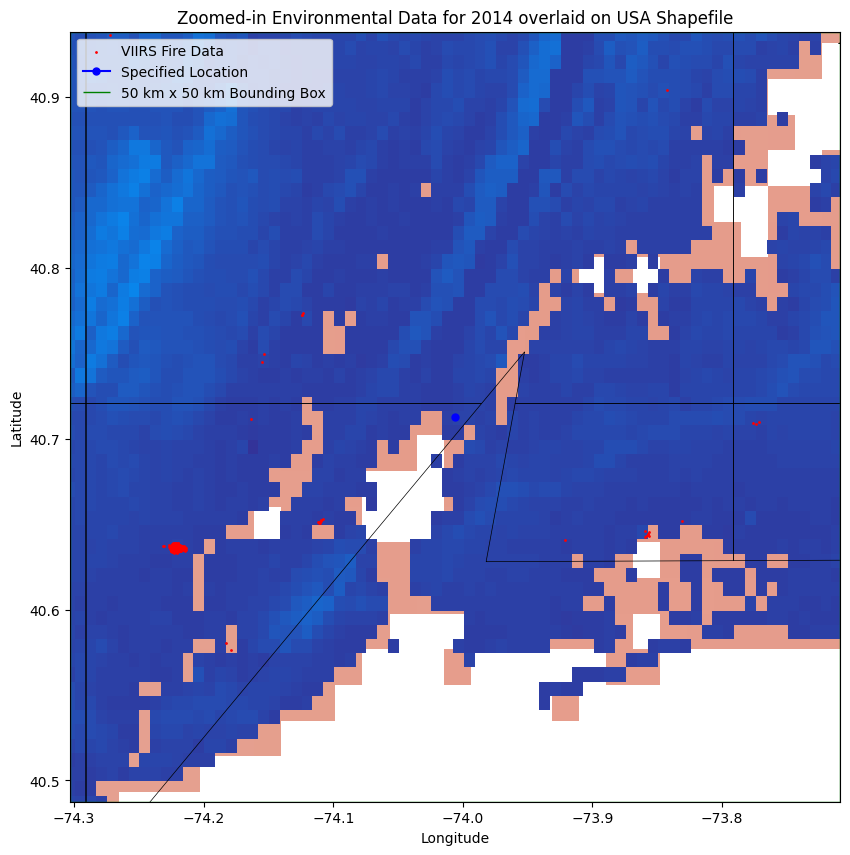

In [ ]:
# Install necessary libraries
!pip install rasterio geopandas matplotlib numpy pandas netCDF4

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change the current directory to the shapefiles folder
%cd '/content/drive/MyDrive/shapefiles/'

import os
import glob
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from shapely.geometry import Point, Polygon
from matplotlib.colors import Normalize
from rasterio.warp import calculate_default_transform, reproject, Resampling
from netCDF4 import Dataset

# Set the year variable
year = 2014  # Change this to the desired year
month = 1  # Change this to the desired month
day = 1  # Change this to the desired day

# Paths to the necessary files
shapefile_path = '/content/drive/MyDrive/shapefiles/regrid.shp'
tif_folder = '/content/drive/MyDrive/elevationtiffiles/'
viirs_csv_path = f'/content/drive/MyDrive/VIIRSFireData/viirsNA{year}.csv'
prcp_tif_path = f'/content/drive/MyDrive/preciipitationtif/daymet_v4_prcp_annttl_na_{year}.tif'
tmax_tif_path = f'/content/drive/MyDrive/newtmaxtif/daymet_v4_tmax_annavg_na_{year}.tif'
vp_tif_path = f'/content/drive/MyDrive/vptif/daymet_v4_vp_annavg_na_{year}.tif'
tmin_tif_path = f'/content/drive/MyDrive/newtmintif/daymet_v4_tmin_annavg_na_{year}.tif'
wind_speed_folder = '/content/drive/MyDrive/wind speed gridmet/'

# Latitude and longitude for the marker
marker_latitude = 40.7128  # example latitude
marker_longitude = -74.0060  # example longitude

# Read the shapefile
grid_shapefile = gpd.read_file(shapefile_path)

# Get the extent of the shapefile
xmin, ymin, xmax, ymax = grid_shapefile.total_bounds

# Plot the shapefile and focus on North America
fig, ax = plt.subplots(figsize=(10, 10))
grid_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Set the axis limits to focus on North America
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Function to reproject and plot TIFF data
def reproject_and_plot_tif(tif_path, ax, cmap, alpha=0.6, label=None):
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        data = np.ma.masked_equal(data, -9999)
        dst_crs = 'EPSG:4326'
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.MemoryFile() as memfile:
            with memfile.open(**kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )
                reprojected_data = dst.read(1)
                reprojected_data = np.ma.masked_equal(reprojected_data, -9999)
                show(reprojected_data, ax=ax, cmap=cmap, transform=transform, norm=Normalize(vmin=reprojected_data.min(), vmax=reprojected_data.max()), alpha=alpha, label=label)

# Function to plot wind speed data from NetCDF
def plot_wind_speed_nc(nc_folder, year, ax, cmap='viridis', alpha=0.6, label='Wind Speed'):
    nc_file = f'{nc_folder}/wind_speed_{year}.nc'
    if os.path.exists(nc_file):
        with Dataset(nc_file) as ds:
            lat = ds.variables['lat'][:]
            lon = ds.variables['lon'][:]
            wind_speed = ds.variables['wind_speed'][:]

            # Mask invalid values
            wind_speed = np.ma.masked_invalid(wind_speed)

            # Create a meshgrid for plotting
            lon, lat = np.meshgrid(lon, lat)

            # Plot wind speed
            cs = ax.pcolormesh(lon, lat, wind_speed, cmap=cmap, alpha=alpha, shading='auto', label=label)
            plt.colorbar(cs, ax=ax, label='Wind Speed (m/s)')

# Plot the precipitation data if available
if os.path.exists(prcp_tif_path):
    reproject_and_plot_tif(prcp_tif_path, ax, cmap='inferno', alpha=0.6, label='Precipitation')

# Plot the vapor pressure data if available
if os.path.exists(vp_tif_path):
    reproject_and_plot_tif(vp_tif_path, ax, cmap='coolwarm', alpha=0.6, label='Vapor Pressure')

# Plot the max temperature data if available
if os.path.exists(tmax_tif_path):
    reproject_and_plot_tif(tmax_tif_path, ax, cmap='plasma', alpha=0.6, label='Max Temperature')

# Plot the min temperature data if available
if os.path.exists(tmin_tif_path):
    reproject_and_plot_tif(tmin_tif_path, ax, cmap='coolwarm', alpha=0.6, label='Min Temperature')

# Plot wind speed data if available
plot_wind_speed_nc(wind_speed_folder, year, ax, cmap='viridis', alpha=0.6, label='Wind Speed')

# Get a list of all elevation TIF files in the folder and sort them
tif_files = sorted(glob.glob(os.path.join(tif_folder, '*.tif')))

# Loop through the TIF files and plot them
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        data = src.read(1, out_shape=(1, int(src.height / 10), int(src.width / 10)))
        data = np.flipud(data)
        transform = rasterio.transform.from_origin(src.bounds.left, src.bounds.top,
                                                   src.res[0] * 10, src.res[1] * 10)
        show(data, ax=ax, cmap='terrain', transform=transform)

# Load the VIIRS fire data if available
fires_within_usa = None
if os.path.exists(viirs_csv_path):
    viirs_data = pd.read_csv(viirs_csv_path)

    # Create a GeoDataFrame from the VIIRS fire data
    geometry = [Point(xy) for xy in zip(viirs_data['longitude'], viirs_data['latitude'])]
    viirs_gdf = gpd.GeoDataFrame(viirs_data, geometry=geometry)

    # Ensure the VIIRS data and the shapefile use the same CRS
    viirs_gdf.crs = {'init': 'epsg:4326'}
    grid_shapefile = grid_shapefile.to_crs(viirs_gdf.crs)

    # Filter the VIIRS data for the year
    viirs_filtered = viirs_gdf[(viirs_gdf['acq_date'] >= f"{year}-01-01") & (viirs_gdf['acq_date'] < f"{year+1}-01-01")]

    # Perform the spatial join operation to keep only the data points within the USA boundary
    fires_within_usa = gpd.sjoin(viirs_filtered, grid_shapefile, how='inner', op='within')

    # Plot the VIIRS fire data on top of the other layers
    fires_within_usa.plot(ax=ax, marker='o', color='red', markersize=1, label='VIIRS Fire Data')

# Plot the marker at the specified latitude and longitude
ax.plot(marker_longitude, marker_latitude, marker='o', color='blue', markersize=5, label='Specified Location')

# Calculate the bounding box coordinates
degree_lat = 50 / 111  # Approximate conversion from km to degrees latitude
degree_lon = 50 / (111 * np.cos(np.radians(marker_latitude)))  # Approximate conversion from km to degrees longitude

lon_min = marker_longitude - (degree_lon / 2)
lon_max = marker_longitude + (degree_lon / 2)
lat_min = marker_latitude - (degree_lat / 2)
lat_max = marker_latitude + (degree_lat / 2)

# Create a Polygon object representing the bounding box
polygon = Polygon([(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max)])

# Create a GeoDataFrame with the bounding box polygon
bbox = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')

# Plot the bounding box on the map
bbox.boundary.plot(ax=ax, edgecolor='green', linewidth=1, label='50 km x 50 km Bounding Box')

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Environmental Data for {year} overlaid on USA Shapefile')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Now generate the zoomed-in plot for the bounding box region
fig, ax = plt.subplots(figsize=(10, 10))

# Set the axis limits to focus on the bounding box
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Plot the shapefile boundary within the bounding box
grid_shapefile.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot the precipitation data if available
if os.path.exists(prcp_tif_path):
    reproject_and_plot_tif(prcp_tif_path, ax, cmap='inferno', alpha=0.6, label='Precipitation')

# Plot the vapor pressure data if available
if os.path.exists(vp_tif_path):
    reproject_and_plot_tif(vp_tif_path, ax, cmap='coolwarm', alpha=0.6, label='Vapor Pressure')

# Plot the max temperature data if available
if os.path.exists(tmax_tif_path):
    reproject_and_plot_tif(tmax_tif_path, ax, cmap='plasma', alpha=0.6, label='Max Temperature')

# Plot the min temperature data if available
if os.path.exists(tmin_tif_path):
    reproject_and_plot_tif(tmin_tif_path, ax, cmap='coolwarm', alpha=0.6, label='Min Temperature')

# Loop through the TIF files and plot them
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        data = src.read(1, out_shape=(1, int(src.height / 10), int(src.width / 10)))
        data = np.flipud(data)
        transform = rasterio.transform.from_origin(src.bounds.left, src.bounds.top,
                                                   src.res[0] * 10, src.res[1] * 10)
        show(data, ax=ax, cmap='terrain', transform=transform)

# Plot the VIIRS fire data on top of the other layers if it exists
if fires_within_usa is not None:
    fires_within_usa.plot(ax=ax, marker='o', color='red', markersize=1, label='VIIRS Fire Data')

# Plot the marker at the specified latitude and longitude
ax.plot(marker_longitude, marker_latitude, marker='o', color='blue', markersize=5, label='Specified Location')

# Plot the bounding box on the map
bbox.boundary.plot(ax=ax, edgecolor='green', linewidth=1, label='50 km x 50 km Bounding Box')

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Zoomed-in Environmental Data for {year} overlaid on USA Shapefile')

# Add legend
plt.legend()

# Show the zoomed-in plot
plt.show()


In [ ]:
import os
import glob
import rasterio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from shapely.geometry import Point, Polygon, box
from matplotlib.colors import Normalize
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from netCDF4 import Dataset

# Create the output directory if it does not exist
output_dir = '/content/drive/MyDrive/output/'
os.makedirs(output_dir, exist_ok=True)

# Function to check if bounding box intersects with raster bounds
def bbox_intersects_raster(bbox, raster_path):
    with rasterio.open(raster_path) as src:
        bbox_crs = bbox.to_crs(src.crs)
        bbox_geom = bbox_crs['geometry'].unary_union
        raster_bounds = src.bounds
        raster_geom = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)
        return bbox_geom.intersects(raster_geom)

# Function to clip and save the raster data within the bounding box
def clip_and_save_tif(tif_path, bounding_box, output_path):
    with rasterio.open(tif_path) as src:
        bbox_geom = bounding_box.to_crs(src.crs)['geometry']
        out_image, out_transform = mask(src, bbox_geom, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

# Define paths for output GeoTIFF files
prcp_output_path = os.path.join(output_dir, 'precipitation_clipped.tif')
vp_output_path = os.path.join(output_dir, 'vapor_pressure_clipped.tif')
tmax_output_path = os.path.join(output_dir, 'tmax_clipped.tif')
tmin_output_path = os.path.join(output_dir, 'tmin_clipped.tif')

# Calculate the bounding box coordinates
degree_lat = 50 / 111  # Approximate conversion from km to degrees latitude
degree_lon = 50 / (111 * np.cos(np.radians(marker_latitude)))  # Approximate conversion from km to degrees longitude

lon_min = marker_longitude - (degree_lon / 2)
lon_max = marker_longitude + (degree_lon / 2)
lat_min = marker_latitude - (degree_lat / 2)
lat_max = marker_latitude + (degree_lat / 2)

# Create a Polygon object representing the bounding box
polygon = Polygon([(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max)])

# Create a GeoDataFrame with the bounding box polygon
bbox = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')

# Clip and save the raster data within the bounding box if they intersect
if os.path.exists(prcp_tif_path) and bbox_intersects_raster(bbox, prcp_tif_path):
    clip_and_save_tif(prcp_tif_path, bbox, prcp_output_path)

if os.path.exists(vp_tif_path) and bbox_intersects_raster(bbox, vp_tif_path):
    clip_and_save_tif(vp_tif_path, bbox, vp_output_path)

if os.path.exists(tmax_tif_path) and bbox_intersects_raster(bbox, tmax_tif_path):
    clip_and_save_tif(tmax_tif_path, bbox, tmax_output_path)

if os.path.exists(tmin_tif_path) and bbox_intersects_raster(bbox, tmin_tif_path):
    clip_and_save_tif(tmin_tif_path, bbox, tmin_output_path)

# Process wind speed data
wind_speed_folder = '/path/to/wind_speed_gridmet/'  # Adjust this path as necessary
wind_speed_files = sorted(glob.glob(os.path.join(wind_speed_folder, '*.nc')))

for wind_speed_file in wind_speed_files:
    with Dataset(wind_speed_file) as ds:
        print(f"Variables in {wind_speed_file}: {list(ds.variables.keys())}")
        if 'time' in ds.variables:
            time_var = ds.variables['time']
            dates = pd.to_datetime(time_var[:], unit='D', origin=pd.Timestamp('1900-01-01'))
            target_date = pd.Timestamp(year, month, day)  # Ensure year, month, and day are defined
            if target_date in dates:
                idx = np.where(dates == target_date)[0][0]
                wind_speed_data = ds.variables['wind_speed'][idx, :, :]
                wind_speed_data = np.flipud(wind_speed_data)  # flip to match TIFF orientation

                wind_speed_output_path = os.path.join(output_dir, f'wind_speed_clipped_{idx}.tif')
                with rasterio.open(wind_speed_output_path, 'w', driver='GTiff', height=wind_speed_data.shape[0],
                                   width=wind_speed_data.shape[1], count=1, dtype=wind_speed_data.dtype,
                                   crs='EPSG:4326') as dst:
                    dst.write(wind_speed_data, 1)
                print(f"Wind speed data for {target_date} saved to {wind_speed_output_path}")
        else:
            print(f"'time' variable not found in {wind_speed_file}")

print("Clipping and saving of raster data within the bounding box is complete.")


Clipping and saving of raster data within the bounding box is complete.


In [ ]:
import os
import glob
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, box
from rasterio.mask import mask
from netCDF4 import Dataset

# Create the output directory if it does not exist
output_dir = '/content/drive/MyDrive/output/'
os.makedirs(output_dir, exist_ok=True)

# Function to check if bounding box intersects with raster bounds
def bbox_intersects_raster(bbox, raster_path):
    with rasterio.open(raster_path) as src:
        bbox_crs = bbox.to_crs(src.crs)
        bbox_geom = bbox_crs['geometry'].unary_union
        raster_bounds = src.bounds
        raster_geom = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)
        return bbox_geom.intersects(raster_geom)

# Function to clip and save the raster data within the bounding box
def clip_and_save_tif(tif_path, bounding_box, output_path):
    with rasterio.open(tif_path) as src:
        bbox_geom = bounding_box.to_crs(src.crs)['geometry']
        out_image, out_transform = mask(src, bbox_geom, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

# Define paths for output GeoTIFF files
prcp_output_path = os.path.join(output_dir, 'precipitation_clipped.tif')
vp_output_path = os.path.join(output_dir, 'vapor_pressure_clipped.tif')
tmax_output_path = os.path.join(output_dir, 'tmax_clipped.tif')
tmin_output_path = os.path.join(output_dir, 'tmin_clipped.tif')

# Ensure the following variables are defined: marker_latitude, marker_longitude, year, month, day

# Calculate the bounding box coordinates
degree_lat = 50 / 111  # Approximate conversion from km to degrees latitude
degree_lon = 50 / (111 * np.cos(np.radians(marker_latitude)))  # Approximate conversion from km to degrees longitude

lon_min = marker_longitude - (degree_lon / 2)
lon_max = marker_longitude + (degree_lon / 2)
lat_min = marker_latitude - (degree_lat / 2)
lat_max = marker_latitude + (degree_lat / 2)

# Create a Polygon object representing the bounding box
polygon = Polygon([(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max)])

# Create a GeoDataFrame with the bounding box polygon
bbox = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')

# Clip and save the raster data within the bounding box if they intersect
if os.path.exists(prcp_tif_path) and bbox_intersects_raster(bbox, prcp_tif_path):
    clip_and_save_tif(prcp_tif_path, bbox, prcp_output_path)

if os.path.exists(vp_tif_path) and bbox_intersects_raster(bbox, vp_tif_path):
    clip_and_save_tif(vp_tif_path, bbox, vp_output_path)

if os.path.exists(tmax_tif_path) and bbox_intersects_raster(bbox, tmax_tif_path):
    clip_and_save_tif(tmax_tif_path, bbox, tmax_output_path)

if os.path.exists(tmin_tif_path) and bbox_intersects_raster(bbox, tmin_tif_path):
    clip_and_save_tif(tmin_tif_path, bbox, tmin_output_path)

# Process wind speed data
wind_speed_folder = '/path/to/wind_speed_gridmet/'  # Adjust this path as necessary
wind_speed_files = sorted(glob.glob(os.path.join(wind_speed_folder, '*.nc')))

for wind_speed_file in wind_speed_files:
    with Dataset(wind_speed_file) as ds:
        print(f"Variables in {wind_speed_file}: {list(ds.variables.keys())}")
        if 'time' in ds.variables:
            time_var = ds.variables['time']
            dates = pd.to_datetime(time_var[:], unit='D', origin=pd.Timestamp('1900-01-01'))
            target_date = pd.Timestamp(year, month, day)  # Ensure year, month, and day are defined
            if target_date in dates:
                idx = np.where(dates == target_date)[0][0]
                wind_speed_var = None
                for var in ds.variables.keys():
                    if 'wind_speed' in var.lower():  # Check for any variable containing 'wind_speed'
                        wind_speed_var = var
                        break

                if wind_speed_var is not None:
                    wind_speed_data = ds.variables[wind_speed_var][idx, :, :]
                    wind_speed_data = np.flipud(wind_speed_data)  # flip to match TIFF orientation

                    wind_speed_output_path = os.path.join(output_dir, f'wind_speed_clipped_{idx}.tif')
                    with rasterio.open(wind_speed_output_path, 'w', driver='GTiff', height=wind_speed_data.shape[0],
                                       width=wind_speed_data.shape[1], count=1, dtype=wind_speed_data.dtype,
                                       crs='EPSG:4326') as dst:
                        dst.write(wind_speed_data, 1)
                    print(f"Wind speed data for {target_date} saved to {wind_speed_output_path}")
                else:
                    print(f"No wind speed variable found in {wind_speed_file}")
            else:
                print(f"Target date {target_date} not found in {wind_speed_file}")
        else:
            print(f"'time' variable not found in {wind_speed_file}")

print("Clipping and saving of raster data within the bounding box is complete.")


Clipping and saving of raster data within the bounding box is complete.


In [ ]:
import os
import glob
import rasterio
from rasterio.merge import merge
from rasterio.enums import Resampling
from netCDF4 import Dataset
import pandas as pd
import numpy as np

# Ensure all input files have the same spatial resolution and extent
def reproject_and_align(src_path, dst_path, dst_crs, dst_transform, dst_width, dst_height):
    with rasterio.open(src_path) as src:
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height,
            'driver': 'GTiff'
        })
        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

# Define paths
output_dir = '/content/drive/MyDrive/output/'
clipped_tifs = sorted(glob.glob(os.path.join(output_dir, '*.tif')))
aligned_dir = os.path.join(output_dir, 'aligned/')
os.makedirs(aligned_dir, exist_ok=True)
aligned_tifs = []

# Determine the target CRS, transform, width, and height
with rasterio.open(clipped_tifs[0]) as src:
    dst_crs = src.crs
    dst_transform = src.transform
    dst_width = src.width
    dst_height = src.height

# Reproject and align all input files
for i, tif_file in enumerate(clipped_tifs):
    aligned_path = os.path.join(aligned_dir, f'aligned_{i}.tif')
    reproject_and_align(tif_file, aligned_path, dst_crs, dst_transform, dst_width, dst_height)
    aligned_tifs.append(aligned_path)

# Process wind speed data
wind_speed_folder = '/path/to/wind_speed_gridmet/'  # Adjust this path as necessary
wind_speed_files = sorted(glob.glob(os.path.join(wind_speed_folder, '*.nc')))
wind_speed_aligned_tifs = []

for wind_speed_file in wind_speed_files:
    with Dataset(wind_speed_file) as ds:
        time_var = ds.variables['time']
        dates = pd.to_datetime(time_var[:], unit='D', origin=pd.Timestamp('1900-01-01'))
        target_date = pd.Timestamp(year, month, day)  # Ensure year, month, and day are defined
        if target_date in dates:
            idx = np.where(dates == target_date)[0][0]
            wind_speed_data = ds.variables['wind_speed'][idx, :, :]
            wind_speed_data = np.flipud(wind_speed_data)  # flip to match TIFF orientation

            wind_speed_output_path = os.path.join(aligned_dir, f'wind_speed_aligned_{idx}.tif')
            aligned_tifs.append(wind_speed_output_path)

            with rasterio.open(wind_speed_output_path, 'w', driver='GTiff', height=wind_speed_data.shape[0],
                               width=wind_speed_data.shape[1], count=1, dtype=wind_speed_data.dtype,
                               crs=dst_crs, transform=dst_transform) as dst:
                dst.write(wind_speed_data, 1)
            wind_speed_aligned_tifs.append(wind_speed_output_path)

# Merge aligned GeoTIFFs into a single multi-band GeoTIFF
def merge_geotiffs(tif_files, output_path):
    with rasterio.open(tif_files[0]) as src0:
        meta = src0.meta

    meta.update(count=len(tif_files))

    with rasterio.open(output_path, 'w', **meta) as dst:
        for id, tif_file in enumerate(tif_files, start=1):
            with rasterio.open(tif_file) as src1:
                dst.write_band(id, src1.read(1))

# Path for the output merged GeoTIFF
merged_output_path = os.path.join(output_dir, 'merged_variables.tif')

# Merge the GeoTIFFs
merge_geotiffs(aligned_tifs, merged_output_path)

print("Merging of GeoTIFFs is complete.")


Merging of GeoTIFFs is complete.
